# Import libraries


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

# Data loading and vizualisation

In [4]:
# Load and preprocess data
X = pd.read_csv("../data/X.csv")
Y = pd.read_csv("../data/Y.csv")["DispFrames"]

# Preprocessing: Remove TimeStamp and missing values
timestamp = X["TimeStamp"]
X.drop(X.columns[0:2], axis=1, inplace=True) # Remove TimeStamp column
X.dropna(how='any', inplace=True) # Drop rows with missing values

# Data preparation

In [5]:
# Data Standardization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [6]:
# Outlier removal using Z-score (commented out here, left as a reference)
# Uncomment to remove extreme outliers based on Z-scores
"""
z_scores = np.abs(stats.zscore(X_scaled))
threshold = 28 # Z-score threshold to detect outliers
X_no_outliers = X_scaled[(z_scores < threshold).all(axis=1)]
Y_no_outliers = Y[(z_scores < threshold).all(axis=1)]
timestamp_no_outliers = timestamp[(z_scores < threshold).all(axis=1)]
"""

# Outlier removal using the IQR method (commented out)
"""
Q1 = X_scaled.quantile(0.25)
Q3 = X_scaled.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5 # IQR threshold for outliers

is_outlier = ((X_scaled < (Q1 - threshold * IQR)) | (X_scaled > (Q3 + threshold * IQR))).any(axis=1)

X_no_outliers = X_scaled[~is_outlier]
Y_no_outliers = Y[~is_outlier]
timestamp_no_outliers = timestamp[~is_outlier]
"""

'\nQ1 = X_scaled.quantile(0.25)\nQ3 = X_scaled.quantile(0.75)\nIQR = Q3 - Q1\nthreshold = 1.5 # IQR threshold for outliers\n\nis_outlier = ((X_scaled < (Q1 - threshold * IQR)) | (X_scaled > (Q3 + threshold * IQR))).any(axis=1)\n\nX_no_outliers = X_scaled[~is_outlier]\nY_no_outliers = Y[~is_outlier]\ntimestamp_no_outliers = timestamp[~is_outlier]\n'

In [7]:
# Function to remove outliers based on a custom threshold
def remove_outliers(X, T):
    df = X.copy()
    outliers = (df.abs() > T).any(axis=1)  # Mark rows where any value exceeds threshold
    df_no_outliers = df[~outliers]  # Remove outliers
    return df_no_outliers, np.array(outliers)

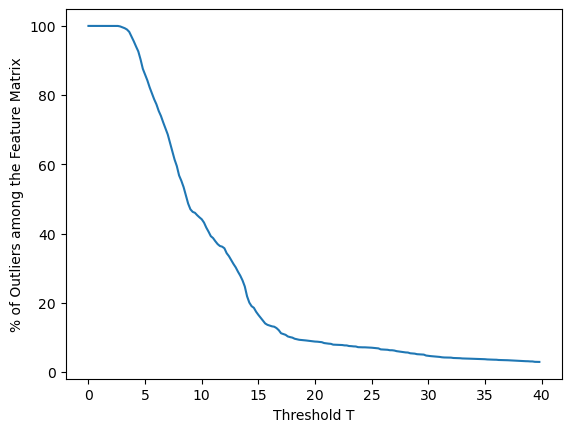

In [8]:
# Testing different thresholds between 0 and 40 to determine outlier removal rate
thresholds = np.arange(0,40,0.2)
num_outliers = []

for T in thresholds :
  df_no_outliers,_ = remove_outliers(X,T)
  num_outliers.append((len(X) - len(df_no_outliers))*100/len(X))

# Plot the outlier percentages against thresholds
plt.plot(thresholds, num_outliers)
plt.xlabel('Threshold T')
plt.ylabel('% of Outliers among the Feature Matrix')
plt.show()

In [9]:
# Remove outliers : we want to keep 95% of the data, let's select T that removes 5% of outliers
num_outliers = np.array(num_outliers)
T = int(thresholds[np.argwhere(num_outliers<5)[0]])
print("The threshold is {}.".format(T))

# Apply the chosen threshold to remove outliers
X_no_outliers, outliers = remove_outliers(X,T)
Y_no_outliers = Y[~outliers]
t_no_outliers = timestamp[~outliers]

The threshold is 29.


/var/folders/b_/bjfw6fm51mn88dk24_v13wsc0000gn/T/ipykernel_33938/3477955566.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T = int(thresholds[np.argwhere(num_outliers<5)[0]])


In [10]:
# Feature selection using RandomForest to find important features
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_no_outliers, Y_no_outliers)
feature_importances = model.feature_importances_

In [9]:
# Selecting top 16 features
"""best_features_idx = np.argsort(feature_importances)[-16:]  # Select top 16 features
best_features = X.columns[best_features_idx]
print('Best features', best_features)"""

#To avoid re-fitting each time
best_features = ['4_i124_intr.s', '3_ldavg.5', '4_cpu8_.sys', '3_i133_intr.s',
       '4_cpu11_.usr', '3_i126_intr.s', '4_cpu4_.usr', '4_cpu10_.idle',
       '0_kbdirty', '4_kbdirty', '4_cpu6_.sys', '4_cpu4_.sys', '4_ldavg.1',
       '4_all_..idle', '2_kbinact', '2_all_..idle']

# Select the important features
X_selected = X_no_outliers.loc[:, best_features]

# Create a new training set and a new test set with samples of structure

In [10]:
# Train/Test Split
T = int(0.7 * len(X_selected)) # 70% for training
X_train, X_test = X_selected.iloc[:T, :], X_selected.iloc[T:, :]
Y_train, Y_test = Y_no_outliers.iloc[:T], Y_no_outliers.iloc[T:]

# Reshaping Data for Time Series Forecasting
# Define a function to create new structured dataset
def create_dataset(X, Y, l=0, h=0, s=1):

    X_new, Y_new = [], []

    for i in range(l, len(X) - h):

        X_new.append(X.iloc[i-l:i+1].to_numpy().flatten())  # Flatten the time windows
        Y_new.append(Y.iloc[i:i+h+1].to_numpy())  # Flatten the target variable

    return np.array(X_new), np.array(Y_new)

# Training Linear Regression Models for different lags (l) and horizons (h)
results = pd.DataFrame(index=range(11), columns=range(11))  # 11x11 table for l and h

for l in range(11):
    for h in range(11):
        X_train_new, Y_train_new = create_dataset(X_train, Y_train, l, h)
        X_test_new, Y_test_new = create_dataset(X_test, Y_test, l, h)

        # Train Linear Regression Model
        model = LinearRegression()
        model.fit(X_train_new, Y_train_new)

        # Predict and Evaluate
        Y_pred = model.predict(X_test_new)
        nmae = mean_absolute_error(Y_test_new, Y_pred) / np.mean(np.abs(Y_test_new))
        results.at[h, l] = nmae

# Display the result table of NMAE values for different l and h

print(results)

In [ ]:
# Feature importance analysis for time series forecasting

def feature_importance_analysis(X_train, Y_train, l, h):

    X_train_new, Y_train_new = create_dataset(X_train, Y_train, l, h)
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train_new, Y_train_new)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-16:]

    print(f"Top 16 features for l = {l} and h = {h}: {indices}")

    return indices

# Analyze feature importance for lag = 10, horizon = 1 and 10
best_features_h1 = feature_importance_analysis(X_train, Y_train, 10, 1)
best_features_h10 = feature_importance_analysis(X_train, Y_train, 10, 10)

# Count feature importance distribution over different lags for horizon = 1 and horizon = 10

h1_distribution,h10_distribution = [],[]

for l in range(11):
    best_features_h1_l = feature_importance_analysis(X_train, Y_train, l, 1)
    best_features_h10_l = feature_importance_analysis(X_train, Y_train, l, 10)
    h1_distribution.append(np.sum(np.isin(best_features_h1,best_features_h1_l)))
    h10_distribution.append(np.sum(np.isin(best_features_h10,best_features_h10_l)))

Top 16 features for l = 10 and h = 1: [172 137 108  79 156 140 153  76 169  95 127 111 124 143 175 159]
Top 16 features for l = 10 and h = 10: [137 153  63  31  79  12 127 169  47 124 174 143 159 156 172 175]


In [ ]:
# Plot feature distribution for h = 1
plt.bar(np.arange(11), h1_distribution, label='h = 1')
plt.xlabel('Lag value l')
plt.ylabel('Count')
plt.title('Distribution of Selected Features over the lags for h = 1')
plt.legend()
plt.show()

# Plot feature distribution for h = 10
plt.bar(np.arange(11),h10_distribution, label='h = 10')
plt.xlabel('Lag value l')
plt.ylabel('Count')
plt.title('Distribution of Selected Features over the lags for h = 10')
plt.legend()
plt.show()

In [ ]:
# Since our dataset is filled with 11 samples of 16 features, we now have 16*11 = 176 features
# Let's see which ones of the 16 features are relevant by looking at the rest of the division by 16

print(best_features_h1)
print(best_features_h1%16)
elements, counts = np.unique(best_features_h1%16, return_counts=True)
features = X_selected.columns[elements]
print(features,counts)

print(best_features_h10)
print(best_features_h10%16)
elements, counts = np.unique(best_features_h10%16, return_counts=True)
features = X_selected.columns[elements]
print(features,counts)